In [1]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

import collections
from datetime import datetime, timedelta
import glob
import os
import sys
import time
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from data import get_data
from utils import plot_forecast, plot_components

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")

## Get the data

In [2]:
num_forecast_steps = 7 * 4 # 28 days

X_original, anoms, clims, temps, dates, \
columnstr_to_index, index_to_columnstr = get_data(add_ones=True)

num_data_to_consider = 365 * 10 # 10 years worth of data
assert(num_data_to_consider > num_forecast_steps)

X_original_train = X_original[-num_data_to_consider:-num_forecast_steps, :]
anoms_train = anoms[-num_data_to_consider:-num_forecast_steps]
clims_train = clims[-num_data_to_consider:-num_forecast_steps]
temps_train = temps[-num_data_to_consider:-num_forecast_steps]
dates_train = dates[-num_data_to_consider:-num_forecast_steps]

X_original_test = X_original[-num_forecast_steps:, :]
anoms_test = anoms[-num_forecast_steps:]
clims_test = clims[-num_forecast_steps:]
temps_test = temps[-num_forecast_steps:]
dates_test = dates[-num_forecast_steps:]

is_predicting_anomaly = False
if is_predicting_anomaly:
    Y_train = anoms_train
    Y_test = anoms_test
    print(f"Y is temperature anomaly!")
else:
    Y_train = temps_train
    Y_test = temps_test
    print(f"Y is temperature directly!")

['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']
lat_oi: 27.0, lon_oi: 261.0
Y is temperature directly!


In [3]:
normalize_features = True
X_normalized = np.zeros_like(X_original)
if normalize_features:
    for col_idx in range(X_original.shape[1]):
        if index_to_columnstr[col_idx] == 'ones':
            X_normalized[:, col_idx] = X_original[:, col_idx]
            continue
        vals = X_original[:, col_idx]
        mean = np.mean(X_original[:, col_idx])        
        std = np.std(X_original[:, col_idx])
        X_normalized[:, col_idx] = (vals - mean) / std
#         print(f"------{index_to_columnstr[col_idx]}")
#         print(np.min(X_normalized[:, col_idx]))
#         print(np.max(X_normalized[:, col_idx]))
#         print(np.mean(X_normalized[:, col_idx]))

X = X_normalized[:, :]
X_train = X_normalized[-num_data_to_consider:-num_forecast_steps, :]
X_test = X_normalized[-num_forecast_steps:, :]


In [4]:
years_in_data = dates.dt.year
first_year = min(years_in_data)
last_year = max(years_in_data)
print(first_year)
print(last_year)

print(index_to_columnstr)

num_forecast_steps = 7 * 4 # 28 days

1982
2018
{0: 'ones', 1: 'tmp2m_shift29', 2: 'tmp2m_shift29_anom', 3: 'tmp2m_shift58', 4: 'tmp2m_shift58_anom', 5: 'rhum_shift30', 6: 'pres_shift30', 7: 'nmme_wo_ccsm3_nasa', 8: 'nmme0_wo_ccsm3_nasa', 9: 'mei_shift45', 10: 'phase_shift17', 11: 'sst_2010_1_shift30', 12: 'sst_2010_2_shift30', 13: 'sst_2010_3_shift30', 14: 'icec_2010_1_shift30', 15: 'icec_2010_2_shift30', 16: 'icec_2010_3_shift30', 17: 'wind_hgt_10_2010_1_shift30', 18: 'wind_hgt_10_2010_2_shift30'}


(3622,)


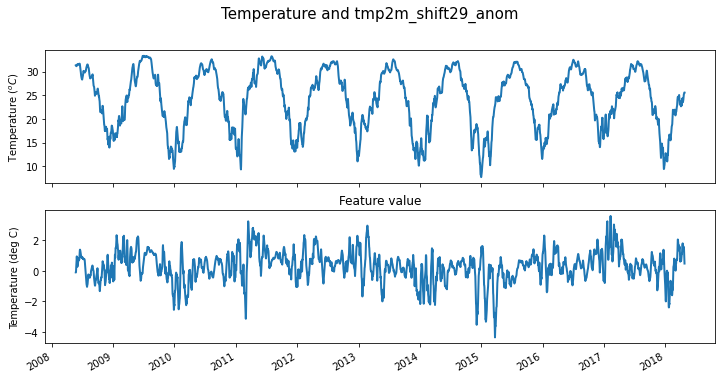

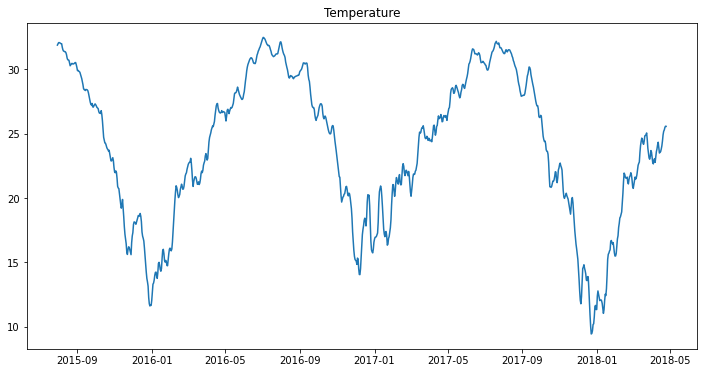

In [5]:
print(Y_train.shape)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates_train,
        Y_train, lw=2, label="training data")
ax.set_ylabel("Temperature ($^oC$)")

ax = fig.add_subplot(2, 1, 2)

feature_str = "tmp2m_shift29_anom"
ax.plot(dates_train,
        X_train[:, columnstr_to_index[feature_str]], lw=2, label="training data")
ax.set_ylabel("Temperature Anomaly (deg C)" if is_predicting_anomaly else "Temperature (deg C)")
ax.set_title("Feature value")
fig.suptitle(f"Temperature Anomaly and {feature_str}" if is_predicting_anomaly else 
             f"Temperature and {feature_str}",
             fontsize=15)
fig.autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.title(f"Temperature Anomaly" if is_predicting_anomaly else f"Temperature")
plt.plot(dates_train[-1000:], Y_train[-1000:])


In [6]:
def build_model(observed_time_series):
#     weekly = tfp.sts.Seasonal(
#         num_seasons=26, 
#         observed_time_series=observed_time_series,
#         num_steps_per_season=14, 
#         name='biweekly'
#     )
#     weekly = tfp.sts.SmoothSeasonal(
#         period=7,
#         frequency_multipliers=[1, 2, 3],
#         initial_state_prior=tfd.MultivariateNormalDiag(scale_diag=tf.ones([6])),
#         observed_time_series=observed_time_series,
#         name='biweekly'
#     )
#     seasonal = tfp.sts.Seasonal(
#         num_seasons=4, 
#         observed_time_series=observed_time_series,
#         num_steps_per_season=91, 
#         name='seasonal'
#     )
#     monthly = tfp.sts.Seasonal(
#         num_seasons=12,
#         observed_time_series=observed_time_series,
#         num_steps_per_season=[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
#         drift_scale_prior=tfd.LogNormal(loc=-1., scale=0.1),
#         initial_effect_prior=tfd.Normal(loc=0., scale=5.),
#         name='month_of_year',
#     )
    features_effects = []
    for feature_name, idx in columnstr_to_index.items():
        features_effects.append(
            tfp.sts.LinearRegression(
                design_matrix=np.expand_dims(X[:, idx], 1),# - np.mean(X), 
                name=f"{feature_name}_{idx}"
            )   
        )
#     autoregressive = tfp.sts.Autoregressive(
#         order=1,
#         observed_time_series=observed_time_series,
#         name='autoregressive'
#     )
#     semilocal = tfp.sts.SemiLocalLinearTrend()
    sts_components = [
#         weekly,
#         seasonal,
#         monthly,
#         autoregressive
#         semilocal
    ] + features_effects
    model = tfp.sts.Sum(
        sts_components,
        observed_time_series=observed_time_series
    )
    return model

temperature_model = build_model(Y_train)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temperature_model)
print(variational_posteriors)

tfp.distributions.JointDistributionNamed("build_factored_surrogate_posterior_JointDistributionNamed", batch_shape={icec_2010_1_shift30_14/_weights: [], icec_2010_2_shift30_15/_weights: [], icec_2010_3_shift30_16/_weights: [], mei_shift45_9/_weights: [], nmme0_wo_ccsm3_nasa_8/_weights: [], nmme_wo_ccsm3_nasa_7/_weights: [], observation_noise_scale: [], ones_0/_weights: [], phase_shift17_10/_weights: [], pres_shift30_6/_weights: [], rhum_shift30_5/_weights: [], sst_2010_1_shift30_11/_weights: [], sst_2010_2_shift30_12/_weights: [], sst_2010_3_shift30_13/_weights: [], tmp2m_shift29_1/_weights: [], tmp2m_shift29_anom_2/_weights: [], tmp2m_shift58_3/_weights: [], tmp2m_shift58_anom_4/_weights: [], wind_hgt_10_2010_1_shift30_17/_weights: [], wind_hgt_10_2010_2_shift30_18/_weights: []}, event_shape={icec_2010_1_shift30_14/_weights: [1], icec_2010_2_shift30_15/_weights: [1], icec_2010_3_shift30_16/_weights: [1], mei_shift45_9/_weights: [1], nmme0_wo_ccsm3_nasa_8/_weights: [1], nmme_wo_ccsm3_na

75
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.
109.93627333641052 seconds


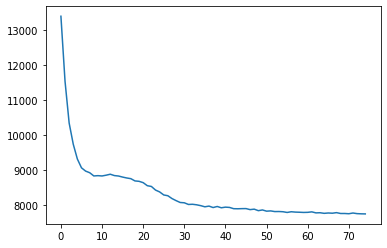

In [7]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 75
print(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=temperature_model.joint_log_prob(
        observed_time_series=Y_train),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"{end - start} seconds")
plt.plot(elbo_loss_curve)
plt.show()

In [8]:
print(elbo_loss_curve)

tf.Tensor(
[13399.738  11543.867  10353.27    9747.982   9325.593   9074.672
  8981.367   8934.443   8842.709   8850.9375  8842.143   8864.334
  8891.742   8853.286   8840.5625  8810.4375  8784.768   8765.018
  8700.885   8689.271   8651.315   8564.798   8542.492   8439.898
  8386.843   8300.321   8277.968   8197.554   8138.3877  8085.414
  8076.9214  8029.309   8034.286   8019.304   7994.76    7962.207
  7982.4766  7941.157   7971.3535  7934.464   7952.6523  7944.379
  7908.3657  7906.0713  7909.933   7911.395   7881.7856  7895.1704
  7851.903   7872.63    7837.7646  7845.0522  7826.146   7827.832
  7821.4463  7801.067   7821.273   7811.1177  7807.032   7801.565
  7804.355   7817.806   7788.6533  7792.9375  7775.8574  7785.5474
  7779.438   7795.5767  7771.4326  7771.529   7764.4717  7784.747
  7767.4966  7761.9463  7759.2686], shape=(75,), dtype=float32)


In [9]:
# Draw samples from the variational posterior.
q_samples_temperature_ = variational_posteriors.sample(50)


print("Inferred parameters:")
for param in temperature_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temperature_[param.name], axis=0),
                              np.std(q_samples_temperature_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 1.970648169517517 +- 0.013046180829405785
ones_0/_weights: [0.0264701] +- [0.03202216]
tmp2m_shift29_1/_weights: [-1.0915021] +- [0.04127599]
tmp2m_shift29_anom_2/_weights: [0.2883049] +- [0.0230209]
tmp2m_shift58_3/_weights: [-1.247753] +- [0.02508353]
tmp2m_shift58_anom_4/_weights: [0.4619574] +- [0.02433079]
rhum_shift30_5/_weights: [-0.03527946] +- [0.05040077]
pres_shift30_6/_weights: [-0.32122365] +- [0.02524521]
nmme_wo_ccsm3_nasa_7/_weights: [-0.90473557] +- [0.04411284]
nmme0_wo_ccsm3_nasa_8/_weights: [0.31680694] +- [0.03818076]
mei_shift45_9/_weights: [-0.42332557] +- [0.02836189]
phase_shift17_10/_weights: [0.01206565] +- [0.02543036]
sst_2010_1_shift30_11/_weights: [-1.7170688] +- [0.03822321]
sst_2010_2_shift30_12/_weights: [0.5769114] +- [0.04156082]
sst_2010_3_shift30_13/_weights: [-1.3087628] +- [0.03500636]
icec_2010_1_shift30_14/_weights: [0.5133504] +- [0.01856588]
icec_2010_2_shift30_15/_weights: [0.5283582] +- [0.03036

## Forecasting

In [10]:
start = time.time()
temperature_forecast_dist = tfp.sts.forecast(
    model=temperature_model,
    observed_time_series=Y_train[-10 * 365:],
    parameter_samples=q_samples_temperature_,
    num_steps_forecast=num_forecast_steps)
end = time.time()
print(f"time elapsed = {end - start}")

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
time elapsed = 437.83526515960693


skill: 0.9064139723777771


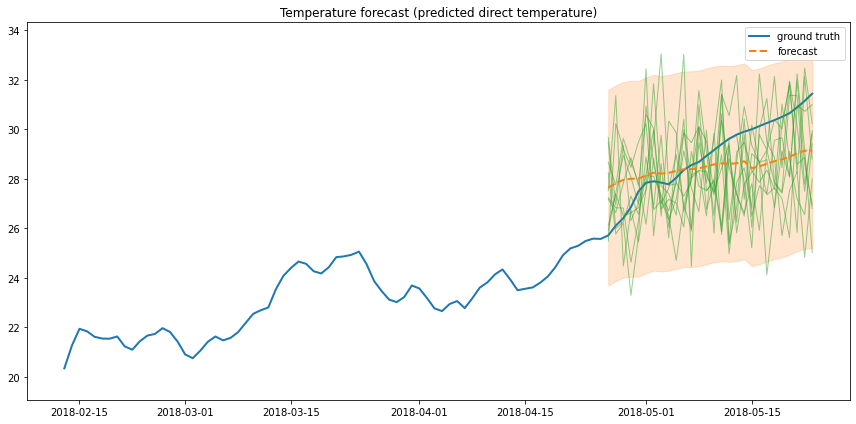

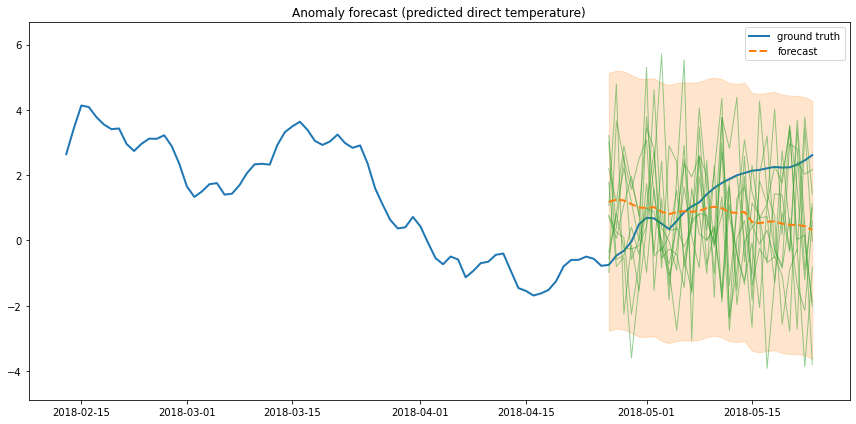

In [11]:
num_samples=10
plot_num = 100

(
    temperature_forecast_mean,
    temperature_forecast_scale,
    temperature_forecast_samples
) = (
    temperature_forecast_dist.mean().numpy()[..., 0],
    temperature_forecast_dist.stddev().numpy()[..., 0],
    temperature_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

if is_predicting_anomaly:
    fig, ax = plot_forecast(dates, anoms + clims,
                            temperature_forecast_mean + clims_test,
                            temperature_forecast_scale,
                            temperature_forecast_samples + clims_test,
                            title="Temperature forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()
    fig, ax = plot_forecast(dates, anoms,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Anomaly forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    
    anoms_hat = temperature_forecast_mean[14:]
    anoms_hat_norm = anoms_hat / np.linalg.norm(anoms_hat)
    anoms_test_norm = anoms_test[14:] / np.linalg.norm(anoms_test[14:])
    print(f"skill: {anoms_hat_norm.dot(anoms_test_norm)}")

    
else:
    fig, ax = plot_forecast(dates, temps,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Temperature forecast (predicted direct temperature)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    fig, ax = plot_forecast(dates, anoms,
                        temperature_forecast_mean - clims_test,
                        temperature_forecast_scale,
                        temperature_forecast_samples - clims_test,
                        title="Anomaly forecast (predicted direct temperature)",
                        plot_num=plot_num,
    )
    fig.tight_layout()
    
    
    anoms_hat = temperature_forecast_mean[14:] - clims_test[14:]
    anoms_hat_norm = anoms_hat / np.linalg.norm(anoms_hat)
    anoms_test_norm = anoms_test[14:] / np.linalg.norm(anoms_test[14:])
    print(f"skill: {anoms_hat_norm.dot(anoms_test_norm)}")



In [19]:
num_to_plot_for_decomp = 8 * 365
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = tfp.sts.decompose_by_component(
    temperature_model,
    observed_time_series=Y_train[-num_to_plot_for_decomp:],
    parameter_samples=q_samples_temperature_
)

forecast_component_dists = tfp.sts.decompose_forecast_by_component(
    temperature_model,
    forecast_dist=temperature_forecast_dist,
    parameter_samples=q_samples_temperature_
)


temperature_component_means_, temperature_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

temperature_forecast_component_means_, temperature_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)


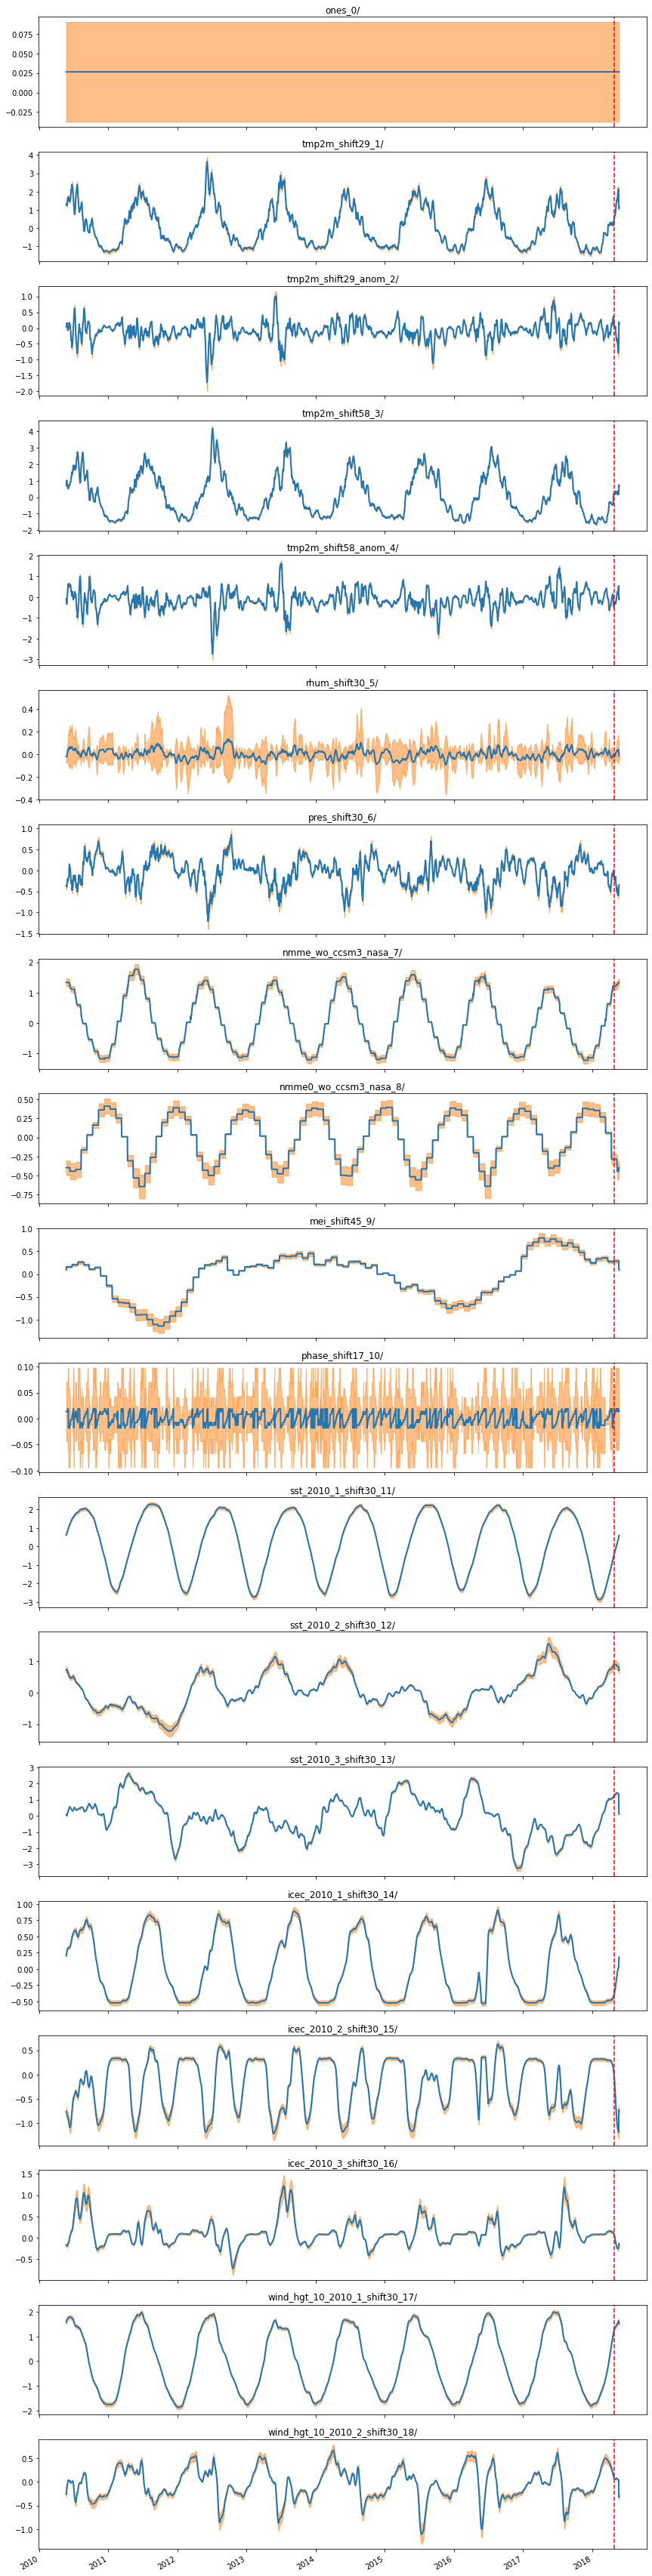

In [20]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
    
for k in temperature_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
        temperature_component_means_[k],
        temperature_forecast_component_means_[k]
    ], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
        temperature_component_stddevs_[k],
        temperature_forecast_component_stddevs_[k]
    ], axis=-1)

fig, axes = plot_components(
    dates[-num_to_plot_for_decomp:],
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    vals_to_plot = num_to_plot_for_decomp
)
for ax in axes.values():
  ax.axvline(dates.to_numpy()[-num_forecast_steps], linestyle="--", color='red')


In [16]:
component_with_forecast_means_[k].shape

(3624,)

In [17]:
temperature_component_means_[k].shape


TensorShape([3622])

In [18]:
temperature_forecast_component_means_[k].shape

TensorShape([2])